<a href="https://colab.research.google.com/github/Ziadnasser1/Machine-Learning-Training/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Builtin Data
Using builtin library to get the data of the `MNIST` data set.

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from skimage.feature import hog
from skimage import exposure

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()


Convert class vectors to binary class matrices

In [ ]:
y_train_BI = to_categorical(y_train_BI, 10)
y_val_BI = to_categorical(y_val_BI, 10)
y_test_BI = to_categorical(y_test_BI, 10)

In [ ]:
print("Training data shape:", x_train_BI.shape)
print("Validation data shape:", x_val_BI.shape)
print("Test data shape:", x_test_BI.shape)
print("Training labels shape:", y_train_BI.shape)
print("Validation labels shape:", y_val_BI.shape)
print("Test labels shape:", y_test_BI.shape)

Training data shape: (48000, 28, 28)
Validation data shape: (12000, 28, 28)
Test data shape: (10000, 28, 28)
Training labels shape: (48000, 10)
Validation labels shape: (12000, 10)
Test labels shape: (10000, 10)


# Manually Get the data
Get the data from Files and making the functions manually.

In [42]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

This is **Load Data** function which is responsible for getting the data from the files in the content.
The files are in compressed in `gzip` format. So the function open them in `binary read` mode.
Then the function load the data in `data` variable by reading the content of the file with `.read()` and convert it to `Numpy Array`.
The `dtype=np.uint8` specifies that the data in the file should be interpreted as unsigned 8-bit integers.
While `offset=16`: Skips the first 16 bytes of the file as they usually contain the meta data.

In [43]:
def load_data(file_path, is_labels=False):
    with gzip.open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8, offset=8 if is_labels else 16)
    if not is_labels:
        num_images = len(data) // (28 * 28)
        data = data.reshape((num_images, 28, 28))
    return data

train_images = load_data('/content/train-images-idx3-ubyte.gz')
train_labels = load_data('/content/train-labels-idx1-ubyte.gz', is_labels=True)
test_images = load_data('/content/t10k-images-idx3-ubyte.gz')
test_labels = load_data('/content/t10k-labels-idx1-ubyte.gz', is_labels=True)

In [44]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


# Plotting the data

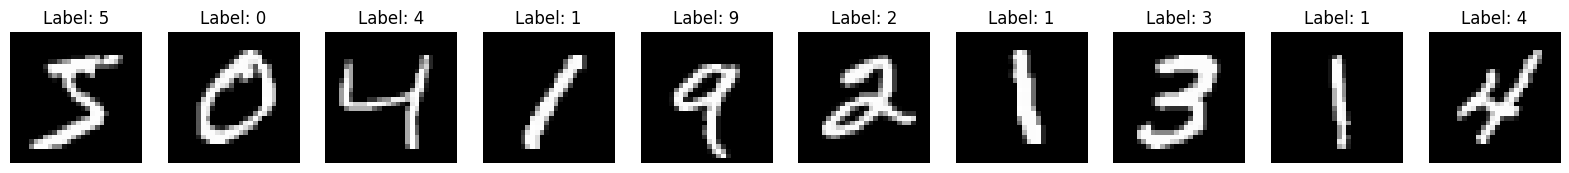

In [45]:
def plot_mnist_images(images, labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))

    for i in range(num_images):
        axes[i].imshow(images[i].reshape(28, 28), cmap='gray')
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off')

    plt.show()

train_images_reshaped = train_images.reshape(-1, 28, 28)
plot_mnist_images(train_images_reshaped, train_labels)

In [46]:
def train_validate_split(images, labels, valRatio=0.2, random_seed=None):
    total_size = len(images)
    val_size = int(total_size * valRatio)
    train_size = total_size - val_size

    np.random.seed(random_seed)
    shuffled_indices = np.random.permutation(total_size)
    train_data, train_labels = images[shuffled_indices[:train_size]], labels[shuffled_indices[:train_size]]
    val_data, val_labels = images[shuffled_indices[train_size:]], labels[shuffled_indices[train_size:]]

    return train_data, train_labels, val_data, val_labels

In [47]:
train_data, train_labels, val_data, val_labels = train_validate_split(train_images, train_labels, random_seed=42)

print(train_data.shape)
print(val_data.shape)
print(test_images.shape)

(48000, 28, 28)
(12000, 28, 28)
(10000, 28, 28)


# Compute Hog Features.

In [48]:
def compute_hog_features(image):
    feature_descriptor = hog(image, orientations=8, pixels_per_cell=(4,4), cells_per_block=(1,1))
    return feature_descriptor

def compute_hog_features_for_all(images):
    hog_features = [compute_hog_features(image) for image in images]
    return np.array(hog_features)

train_hog_features = compute_hog_features_for_all(train_data)
val_hog_features = compute_hog_features_for_all(val_data)
test_hog_features = compute_hog_features_for_all(test_images)

print(train_hog_features.shape)
print(val_hog_features.shape)
print(test_hog_features.shape)

(48000, 392)
(12000, 392)
(10000, 392)


In [49]:
# Reshape the data to be 2D
train_data_flat = train_data.reshape((train_data.shape[0], -1))
val_data_flat = val_data.reshape((val_data.shape[0], -1))
test_data_flat = test_images.reshape((test_images.shape[0], -1))

# Using Builtin KNN on the data.


In [50]:
# Original pixel data using KNN
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(train_data_flat, train_labels)

val_predictions = knn_classifier.predict(val_data_flat)
accuracy = accuracy_score(val_labels, val_predictions)
print("Accuracy on validation set (original data): {:.2%}".format(accuracy))

test_predictions = knn_classifier.predict(test_data_flat)
accuracy = accuracy_score(test_labels, test_predictions)
print("Accuracy on test set (original data): {:.2%}".format(accuracy))

# HOG feature data using KNN
knn_classifier_hog = KNeighborsClassifier(n_neighbors=3)
knn_classifier_hog.fit(train_hog_features, train_labels)

val_predictions_hog = knn_classifier_hog.predict(val_hog_features)
accuracy_hog = accuracy_score(val_labels, val_predictions_hog)
print("Accuracy on validation set (HOG features): {:.2%}".format(accuracy_hog))

test_predictions_hog = knn_classifier_hog.predict(test_hog_features)
accuracy_hog = accuracy_score(test_labels, test_predictions_hog)
print("Accuracy on test set (HOG features): {:.2%}".format(accuracy_hog))


Accuracy on validation set (original data): 97.02%
Accuracy on test set (original data): 96.90%
Accuracy on validation set (HOG features): 96.45%
Accuracy on test set (HOG features): 96.19%


# Using Builtin Bayesian classifier on the data


In [51]:
# Original pixel data using Bayesian
nb_classifier = GaussianNB(var_smoothing = 1e-2)
nb_classifier.fit(train_data_flat, train_labels)

val_predictions_nb = nb_classifier.predict(val_data_flat)
accuracy_nb = accuracy_score(val_labels, val_predictions_nb)
print("Accuracy on validation set (Naive Bayes - original data): {:.2%}".format(accuracy_nb))

test_predictions_nb = nb_classifier.predict(test_data_flat)
accuracy_nb_test = accuracy_score(test_labels, test_predictions_nb)
print("Accuracy on test set (Naive Bayes - original data): {:.2%}".format(accuracy_nb_test))

# HOG feature data using Bayesian
nb_classifier_hog = GaussianNB(var_smoothing = 1e-2)
nb_classifier_hog.fit(train_hog_features, train_labels)

val_predictions_nb_hog = nb_classifier_hog.predict(val_hog_features)
accuracy_nb_hog = accuracy_score(val_labels, val_predictions_nb_hog)
print("Accuracy on validation set (Naive Bayes - HOG features): {:.2%}".format(accuracy_nb_hog))

test_predictions_nb_hog = nb_classifier_hog.predict(test_hog_features)
accuracy_nb_hog_test = accuracy_score(test_labels, test_predictions_nb_hog)
print("Accuracy on test set (Naive Bayes - HOG features): {:.2%}".format(accuracy_nb_hog_test))

Accuracy on validation set (Naive Bayes - original data): 78.10%
Accuracy on test set (Naive Bayes - original data): 78.98%
Accuracy on validation set (Naive Bayes - HOG features): 86.22%
Accuracy on test set (Naive Bayes - HOG features): 87.26%


# Using Builtin Support Vector Machine (SVM) on the data

In [52]:
#Original pixel data using SVM
svm_classifier = LinearSVC()
svm_classifier.fit(train_data_flat, train_labels)


val_predictions_svm = svm_classifier.predict(val_data_flat)
accuracy_svm = accuracy_score(val_labels, val_predictions_svm)
print("Accuracy on validation set (SVM - original data): {:.2%}".format(accuracy_svm))

test_predictions_svm = svm_classifier.predict(test_data_flat)
accuracy_svm_test = accuracy_score(test_labels, test_predictions_svm)
print("Accuracy on test set (SVM - original data): {:.2%}".format(accuracy_svm_test))

# SVM on HOG features
train_hog_features_2d = train_hog_features.reshape((train_hog_features.shape[0], -1))
val_hog_features_2d = val_hog_features.reshape((val_hog_features.shape[0], -1))
test_hog_features_2d = test_hog_features.reshape((test_hog_features.shape[0], -1))

svm_classifier_hog = LinearSVC()
svm_classifier_hog.fit(train_hog_features_2d, train_labels)

val_predictions_svm_hog = svm_classifier_hog.predict(val_hog_features_2d)
accuracy_svm_hog = accuracy_score(val_labels, val_predictions_svm_hog)
print("Accuracy on validation set (SVM - HOG features): {:.2%}".format(accuracy_svm_hog))

test_predictions_svm_hog = svm_classifier_hog.predict(test_hog_features_2d)
accuracy_svm_hog_test = accuracy_score(test_labels, test_predictions_svm_hog)
print("Accuracy on test set (SVM - HOG features): {:.2%}".format(accuracy_svm_hog_test))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy on validation set (SVM - original data): 84.51%
Accuracy on test set (SVM - original data): 84.88%
Accuracy on validation set (SVM - HOG features): 97.09%
Accuracy on test set (SVM - HOG features): 97.19%


# Report for each model.

In [61]:
from sklearn.metrics import classification_report

knnReport = classification_report(test_labels, test_predictions)
print("KNN Report :\n" + knnReport)
print("-------------------------------------------------")
GNBReport = classification_report(test_labels, test_predictions_nb)
print("GNB Report:\n" + GNBReport)
print("-------------------------------------------------")
SVMReport = classification_report(test_labels, test_predictions_svm)
print("SVM Report:\n" + SVMReport)

KNN Report :
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.96      1.00      0.98      1135
           2       0.98      0.97      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.98      0.96      0.97       982
           5       0.97      0.96      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.97       974
           9       0.95      0.96      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

-------------------------------------------------
GNB Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       980
           1       0.86      0.96      0.91      1135
   

# KNN Classifier manually implemented.

In [53]:
class KNNClassifier:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)

    def _predict(self, x):
        distances = np.sqrt(np.sum((self.X_train[:, np.newaxis] - x) ** 2, axis=2))
        k_neighbors_indices = np.argpartition(distances, self.k, axis=0)[:self.k]

        k_neighbor_labels = self.y_train[k_neighbors_indices]

        predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=k_neighbor_labels)

        return predictions


In [54]:
my_knn_classifier = KNNClassifier()
my_knn_classifier.fit(train_data_flat, train_labels)

val_prediction = my_knn_classifier.predict(val_data_flat)
accuracy = accuracy_score(val_labels, val_prediction)
print("Accuracy on validation set: {:.2%}".format(accuracy))

test_prediction = my_knn_classifier.predict(test_data_flat)
accuracy = accuracy_score(test_labels, test_prediction)
print("Accuracy on test set: {:.2%}".format(accuracy))


Accuracy on validation set: 25.45%
Accuracy on test set: 24.79%


# Bayesian Classifier manually implemented

In [39]:
class GaussianNaiveBayes:
    def __init__(self):
        self.Wprob = None
        self.Xprob = None

    def fit(self, X, Y):
        self.Wprob = {label: np.mean(Y == label) for label in set(Y)}
        self.Xprob = {}
        for label in set(Y):
            label_mask = (Y == label)
            self.Xprob[label] = {
                'mean': np.mean(X[label_mask], axis=0),
                'std': np.std(X[label_mask], axis=0) + 1e-8
            }

    def gaussian_disc(self, x, label):
        std = self.Xprob[label]['std']
        eps = 1e-8
        std_plus_eps = std + eps
        probs = np.exp(-0.5 * ((x - self.Xprob[label]['mean']) / std_plus_eps)**2 - 0.5 * np.log(2 * np.pi * std_plus_eps))
        return probs

    def predict(self, T):
        pred_list = []
        for sample in T:
            likelihoods = {
                label: np.sum(np.log(self.gaussian_disc(sample, label)))
                for label in self.Wprob
            }
            posteriors = {
                label: likelihoods[label] + np.log(self.Wprob[label])
                for label in self.Wprob
            }
            predicted_class = max(posteriors, key=posteriors.get)
            pred_list.append(predicted_class)
        return pred_list

In [40]:
gnb_classifier = GaussianNaiveBayes()
gnb_classifier.fit(train_data_flat, train_labels)

val_prediction = gnb_classifier.predict(val_data_flat)
accuracy = accuracy_score(val_labels, val_prediction)
print("Accuracy on validation set: {:.2%}".format(accuracy))

test_prediction = gnb_classifier.predict(test_data_flat)
accuracy = accuracy_score(test_labels, test_prediction)
print("Accuracy on test set: {:.2%}".format(accuracy))

<ipython-input-39-07fb7475b87e>:27: RuntimeWarning: divide by zero encountered in log
  label: np.sum(np.log(self.gaussian_disc(sample, label)))


Accuracy on validation set: 55.47%


<ipython-input-39-07fb7475b87e>:27: RuntimeWarning: divide by zero encountered in log
  label: np.sum(np.log(self.gaussian_disc(sample, label)))


Accuracy on test set: 54.21%
